In [1]:
!git clone https://github.com/YuanGongND/ast.git
!git clone https://github.com/NimayRKumar/in_the_jungle.git
!apt install python3.10-venv
!python3 -m venv venvast
!source venvast/bin/activate

fatal: destination path 'ast' already exists and is not an empty directory.
Cloning into 'in_the_jungle'...
remote: Enumerating objects: 938, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 938 (delta 28), reused 84 (delta 20), pack-reused 843
Receiving objects: 100% (938/938), 103.81 MiB | 8.10 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (891/891), done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10-venv is already the newest version (3.10.12-1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
%cd ast

/content/ast


# The requirements.txt from the AST github have deprecated versions, use the following instead:
llvmlite

matplotlib==3.4.2

numba

numpy

scikit-learn

scipy

timm==0.4.5

torch

torchaudio

torchvision

wget

zipp

In [3]:
!pip install -r requirements.txt

In [4]:
%cd src
from models import ASTModel

/content/ast/src


In [5]:
%cd ../../in_the_jungle

/content/in_the_jungle


In [6]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.9 MB/s eta 0:00:00


In [7]:
!echo -n "/content/in_the_jungle/data" > data_dir_path.txt

In [8]:
!ls

ast.ipynb  data_dir_path.txt	preprocess.py  README.md	 Store	    vgg_pretrained.ipynb
data	   label_encoding.JSON	__pycache__    requirements.txt  vgg.ipynb


In [9]:
from preprocess import create_signal, pad_or_trim_audio, label_encoding
import numpy as np
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import shutil
import json
from ast import literal_eval
from audiomentations import AddGaussianNoise, AirAbsorption, ApplyImpulseResponse, BandPassFilter, GainTransition, RepeatPart, TimeStretch, TanhDistortion
from sklearn.model_selection import train_test_split
import time
import copy

def get_spectrogram(signal, sr=22050):
  spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr)
  return librosa.amplitude_to_db(spectrogram)

def get_mfcc(signal, n_mfcc=13):
    return librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc)


In [10]:
with open("./data_dir_path.txt") as f:
    data_dir = f.read()

print(data_dir)

df = pd.DataFrame(columns=["signal", "label"])
subdirs = [f for f in os.listdir(data_dir) if not f.startswith('.')]

for sd in subdirs:
    out_path = "{}/{}".format(data_dir, sd)
    for file in os.listdir("{}/wav".format(out_path)):
        sig = create_signal("{}/wav/{}".format(out_path, file), out_path)
        sig = pad_or_trim_audio(sig, 22050 * 2)
        df.loc[len(df)] = [sig, label_encoding[sd]]


signal = np.vstack(df["signal"])
label = np.array(df["label"])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_train, x_test, y_train, y_test = train_test_split(signal, label, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

spectrogram_train = get_spectrogram(x_train, sr=16000)
print(spectrogram_train.shape)

mfcc_train = get_mfcc(x_train)
print(mfcc_train.shape)

/content/in_the_jungle/data
(700, 44100) (700,) (175, 44100) (175,)
(700, 128, 87)
(700, 13, 87)


In [11]:
train_data_spectrogram = []
train_data_mfcc = []
for i in range(spectrogram_train.shape[0]):
    train_data_spectrogram.append((spectrogram_train[i], y_train[i]))
    train_data_mfcc.append((mfcc_train[i], y_train[i]))
train_loader_spectrogram = torch.utils.data.DataLoader(train_data_spectrogram, batch_size=32)
train_loader_mfcc = torch.utils.data.DataLoader(train_data_mfcc, batch_size=32)

In [12]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        print("epoch", epoch)
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            # if (i+1) % 1000 == 0:
            #   print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            # if plot:
            #   info = { ('loss_' + model_name): loss.item() }

              #for tag, value in info.items():
                #logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        # model.eval()
        # with torch.no_grad():
        #     correct = 0
        #     total = 0
        #     for i, (images, labels) in enumerate(test_loader):
        #         images = images.to(device)
        #         labels = labels.to(device)
        #         outputs = model(images)
        #         _, predicted = torch.max(outputs.data, 1)
        #         total += labels.size(0)
        #         correct += (predicted == labels).sum().item()

        # print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        # val_error.append(100-100*correct/total)
        # val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values

In [13]:
ast_mdl = ASTModel(label_dim=10, input_tdim=128, input_fdim=87, audioset_pretrain=False, imagenet_pretrain=False)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=96


In [14]:
model = ast_mdl.to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=10e-5, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, train_loader_spectrogram, None, epochs)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99


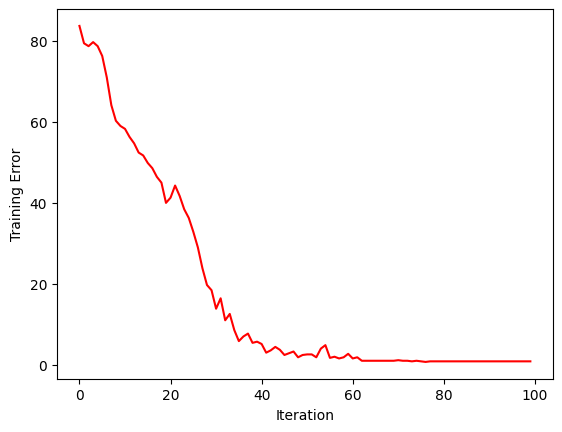

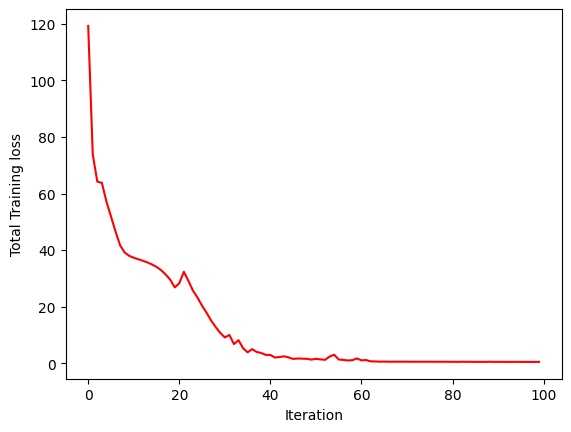

In [16]:
plt.plot(train_error, 'r')
plt.xlabel('Iteration')
plt.ylabel('Training Error')
plt.show()

plt.plot(train_loss_values, 'r')
plt.xlabel('Iteration')
plt.ylabel('Total Training loss')
plt.show()

In [18]:
print(train_error[0], train_error[-1])

83.71428571428572 0.8571428571428612


In [20]:
ast_mdl2 = ASTModel(label_dim=10, input_tdim=13, input_fdim=87, audioset_pretrain=False, imagenet_pretrain=False)
model2 = ast_mdl2.to(device)
epochs = 100
criterion2 = nn.CrossEntropyLoss()

optimizer2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=10e-5, nesterov=True)
val_error2,val_loss_values2,train_error2,train_loss_values2= train(model2, optimizer2, criterion2, train_loader_mfcc, None, epochs)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False


RuntimeError: ignored